In [280]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn import *
import matplotlib.pyplot as plt # to better format confusion matrix
import pandas as pd
import numpy as np
import seaborn as sns

In [281]:
df = pd.read_csv('../data/all_deaths_clean.csv', encoding='utf-8')

Here we are building an ARIMA model to see if the rate of female deaths in prison nationwide is predictable. Since a time series is (obviously) time-dependent, a linear regression model that assumes observations are independent will not work for this prediction.

**ARIMA stands for “autoregressive integrated moving average” and is a model that is often used in statistics and econometrics to predict events that happen over a period of time in a series.**

First, we must group the dataframe by year and gender, keeping only the female data. This data is modified to (rather than represent raw death count per year) show the percent of national prison deaths that were women of that specific year.

In [282]:
# group by year anbd gender then find percentages by gender
df_by_gender = df.groupby(["year","gender"])["id"].count().groupby(level=0).transform(lambda x: x/x.sum()*100).reset_index(name="percent")

# remove male data
df_female_deaths_by_year = df_by_gender.loc[df_by_gender["gender"]=="f"].reset_index(drop=True)



print(df_female_deaths_by_year.head())

   year gender    percent
0  2008      f  12.293144
1  2009      f  10.642202
2  2010      f  11.151737
3  2011      f  11.313869
4  2012      f  13.035714


Visualizing the clean dataframe's data, a clear trend is not noticeable other than irregular increases over the years.

<AxesSubplot: xlabel='year', ylabel='percent'>

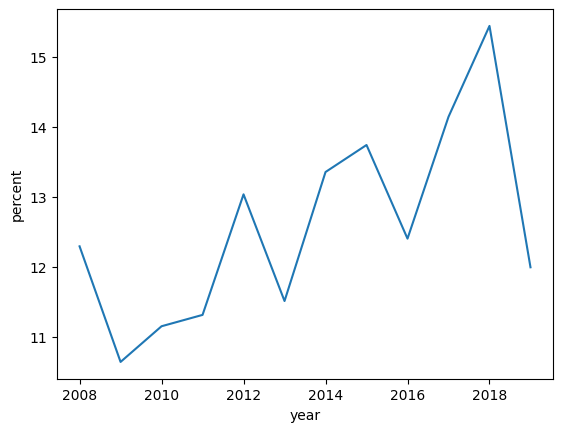

In [283]:
sns.lineplot(data=df_female_deaths_by_year, x="year", y="percent")

We need to split the data into training and testing data for our model to assess its accuracy. *A major downside to this data is that there are not many datapoints, which suggests right off the bat that our model might not be accurate.*

In [284]:
model_df = df_female_deaths_by_year[["percent"]]
msk = (model_df.index < len(model_df)-6)
df_train = model_df[msk].copy()
df_test = model_df[~msk].copy()

We must check if the data is stationary, because if it is not, we cannot use an ARIMA model that assumes stationary data. To do this, we use the Augmented Dickey-Fuller (ADF) Test.

In [285]:
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

if adf_test[1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ")

p-value: 0.2094337407338982
Fail to reject H0 thereby data is non-stationary 


Since the data is not stationary, we need to difference the data to *make* it stationary.

<AxesSubplot: >

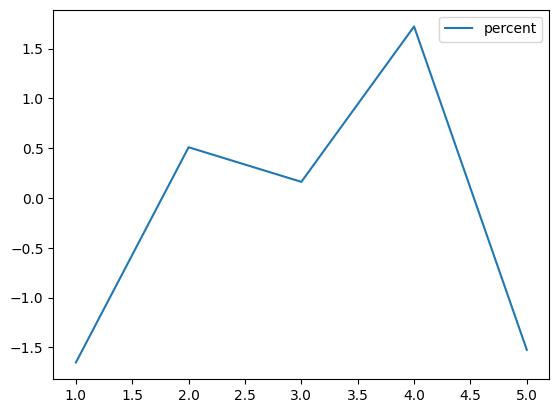

In [286]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

In [287]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

if adf_test[1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ")

p-value: 0.05484932240107959
Fail to reject H0 thereby data is non-stationary 


Testing again, we see that the differenced data is still not quite stationary, but it is within a few one thousandths of being so. For the sake of performing this analysis, we will now build the model.

For the ARIMA model, we must determine the parameters to be used. This is done simply by leveraging the `pmdarima` API which is translates R's `auto-arima` function. This is perfect for someone who is lazy like me.

In [288]:
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    6
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -11.133
Date:                Mon, 05 Dec 2022   AIC                             28.266
Time:                        22:22:11   BIC                             27.641
Sample:                             0   HQIC                            25.765
                                  - 6                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.004    284.680      0.000       0.993       1.007
ma.L1         -0.9778     27.512     -0.036      0.972     -54.900      52.945
sigma2         0.7625     20.502      0.037      0.970     -39.421      40.946
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.45   Prob(JB):                         0.87
Heteroskedasticity (H):               1.12   Skew:                             0.23
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Next, we will fit the model using the (1,0,1) order as recommended by the `auto_arima` function from the `pmdarima` package.

In [289]:
model = ARIMA(df_train, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                percent   No. Observations:                    6
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  -6.357
Date:                Mon, 05 Dec 2022   AIC                             20.713
Time:                        22:22:11   BIC                             19.880
Sample:                             0   HQIC                            17.379
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6141      0.310     37.474      0.000      11.007      12.222
ar.L1          0.3345      1.330      0.251      0.801      -2.272       2.941
ma.L1         -0.9999   5016.629     -0.000      1.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Testing the residuals and density of the model:

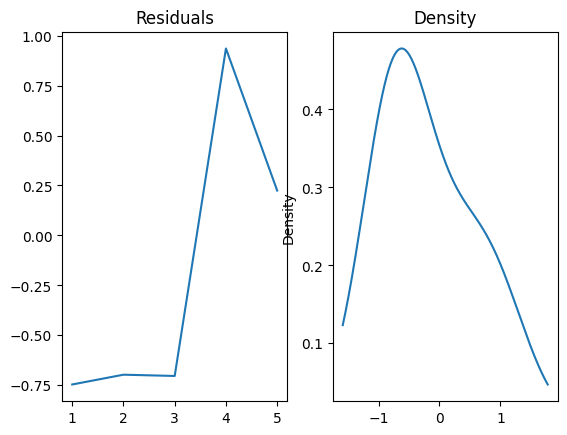

In [290]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

***It is crucial to notice that the residuals are not approximately normally distributed, meaning we cannot take valid statistical inderence from this data (unfortunately).***

Now, we can finally make predictions with the model:

/var/folders/n1/69vwm04j1cn55r3199fbsp_h0000gn/T/ipykernel_31566/2175073197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)


<AxesSubplot: >

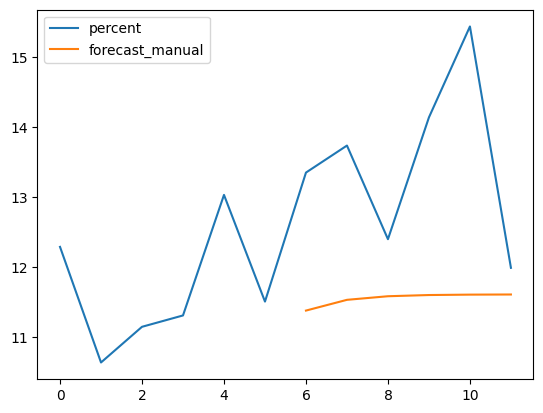

In [291]:
forecast_test = model_fit.forecast(len(df_test))
model_df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
model_df.plot()

As can be easily noticed, the model is not accurate. This makes sense considering how few data points there are. Interestingly, though, the final modeled forecasted value is close to the actual 12% death rate at the end of the graph.